The data set includes title, text, url and human labeled category. All 3 -- title, text and url can inform us about category. But I belive the most rubust one is the *text*. The intuition behind that is:
* Some times titles tries to be creatives and missleading, like "il pastore tedesco" that was the headline of the a left italian newspaper in April 2005, or "The importance of being erroneous" which is about mutations in virouses.
* url is informative, and it can help to construct a nice descision tree, but it is not generalizable, it would not work when a new source is intruduced, and when there is a change in url pattern of a website. 

So here I prefere to stick to "text".

The data here are not enough to construct my own word embedding, so I take a pretrained model and use it here. I go to TensorFlow Hub and choose a model that is close to our problem, runs on my laptop (no GPU) and doesn't take ages to download, and it also works with TF 2.

That leaves me with **nnlm-en-dim50-with-normalization** which is trained on google news, very similar data set :) 

In [1]:
import pandas as pd
df = pd.read_table('../data/data_redacted.tsv')

In [2]:
df.sample(3)

,title,text,url,category
8391,33 Healthy Foods That Are Way More Nutritious ...,"Sure, apples, broccoli, olives, and yogurt mak...",http://www.rd.com/health/healthy-eating/health...,fashion_beauty_lifestyle
3719,Ducati 1199 Superleggera Recall Due to Possibl...,Ducati’s dreamcycle – the 1199 Superleggera – ...,https://ultimatemotorcycling.com/2016/06/20/du...,cars_motors
6340,Miss Colombia stripped of Miss Universe crown ...,Miss Colombia was declared the winner of the b...,http://www.telegraph.co.uk/news/worldnews/nort...,people_shows


In [3]:
df.category.value_counts()

fashion_beauty_lifestyle    1398
sports                      1165
technology_science          1040
digital_life                 738
money_business               733
news                         646
music                        568
culture                      547
travel                       544
cars_motors                  470
politics                     430
people_shows                 367
Name: category, dtype: int64

* I would also consider adding the element of time to the data set. For example, around US election, there will be a spike in political articles. Or perhaps there might be some syncronus behaviur among sources. 
* 

In [4]:
n = df.category.nunique()  # number of categories. 
# Make a sparse matrix out of categories. 
target = pd.get_dummies(df.category, columns=['category'])  # not the best way to do this :) , I am aware of that. 

In [5]:
# Split data into train and test sets. 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.text, target, test_size=0.2)

## The Baseline
The logloss of the mean field approximation:

In [6]:
# First let see what is the performance of the mean field solution.
import numpy as np
-(np.log(y_train.mean()) * y_train).mean().sum()

2.4043158901085233

## The model

In [7]:
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow.keras as keras

# Just an embedding that is trained on google news.
nnlm = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2",
                           input_shape=[], dtype=tf.string)

# Construct a simple neural net that output probabilities of each category for a given text. 
model = keras.Sequential()
model.add(nnlm)
model.add(keras.layers.Dense(25, activation='relu'))  # no parameter tuning for now. 
model.add(keras.layers.Dense(n, activation='sigmoid'))
model.add(keras.layers.Activation('softmax'))
#opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', metrics=keras.metrics.AUC())
model.summary()

2021-10-18 02:40:13.012526: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-18 02:40:13.053874: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 12)                312       
_________________________________________________________________
activation (Activation)      (None, 12)                0         
Total params: 48,192,187
Trainable params: 1,587
Non-trainable params: 48,190,600
_________________________________________________________________


In [8]:
# Train the model.
model.fit(X_train, y_train, epochs=10, validation_split=0.1, shuffle=True)

Epoch 1/10
195/195 [==============================] - 2s 7ms/step - loss: 2.2654 - auc: 0.7968 - val_loss: 2.1177 - val_auc: 0.8985
Epoch 2/10
195/195 [==============================] - 1s 6ms/step - loss: 2.0300 - auc: 0.9335 - val_loss: 1.9731 - val_auc: 0.9483
Epoch 3/10
195/195 [==============================] - 1s 6ms/step - loss: 1.9267 - auc: 0.9577 - val_loss: 1.9076 - val_auc: 0.9596
Epoch 4/10
195/195 [==============================] - 1s 6ms/step - loss: 1.8767 - auc: 0.9647 - val_loss: 1.8738 - val_auc: 0.9640
Epoch 5/10
195/195 [==============================] - 1s 6ms/step - loss: 1.8480 - auc: 0.9684 - val_loss: 1.8513 - val_auc: 0.9660
Epoch 6/10
195/195 [==============================] - 1s 6ms/step - loss: 1.8295 - auc: 0.9706 - val_loss: 1.8372 - val_auc: 0.9679
Epoch 7/10
195/195 [==============================] - 1s 6ms/step - loss: 1.8163 - auc: 0.9716 - val_loss: 1.8248 - val_auc: 0.9683
Epoch 8/10
195/195 [==============================] - 1s 6ms/step - loss: 1.

In [9]:
# Make prediction
model.predict(X_test).argmax(axis=1)

array([ 3,  0,  9, ..., 10,  2,  2])

In [10]:
# The original labels
y_test.values.argmax(axis=1)

array([ 3,  0,  9, ..., 10,  2,  2])

In [11]:
# Evaluate model on the test set. 
model.evaluate(X_test, y_test)

55/55 [==============================] - 0s 7ms/step - loss: 1.7920 - auc: 0.9755


[1.7919983863830566, 0.9754910469055176]

In [12]:
_ = pd.DataFrame({'category': df.category.unique()}, index=range(-n,0))
_['text'] = _.category.str.replace('_', ' ')
df = df.append(_)

In [13]:
embedding = nnlm.call(df.text).numpy()

In [14]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1)
z = tsne.fit_transform(embedding) 

/home/h.allaei/venvs/scientificProject/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/h.allaei/venvs/scientificProject/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8658 samples in 0.001s...
[t-SNE] Computed neighbors for 8658 samples in 1.795s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8658
[t-SNE] Computed conditional probabilities for sample 2000 / 8658
[t-SNE] Computed conditional probabilities for sample 3000 / 8658
[t-SNE] Computed conditional probabilities for sample 4000 / 8658
[t-SNE] Computed conditional probabilities for sample 5000 / 8658
[t-SNE] Computed conditional probabilities for sample 6000 / 8658
[t-SNE] Computed conditional probabilities for sample 7000 / 8658
[t-SNE] Computed conditional probabilities for sample 8000 / 8658
[t-SNE] Computed conditional probabilities for sample 8658 / 8658
[t-SNE] Mean sigma: 0.818158
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.784103
[t-SNE] KL divergence after 1000 iterations: 2.029694


<AxesSubplot:xlabel='comp-1', ylabel='comp-2'>

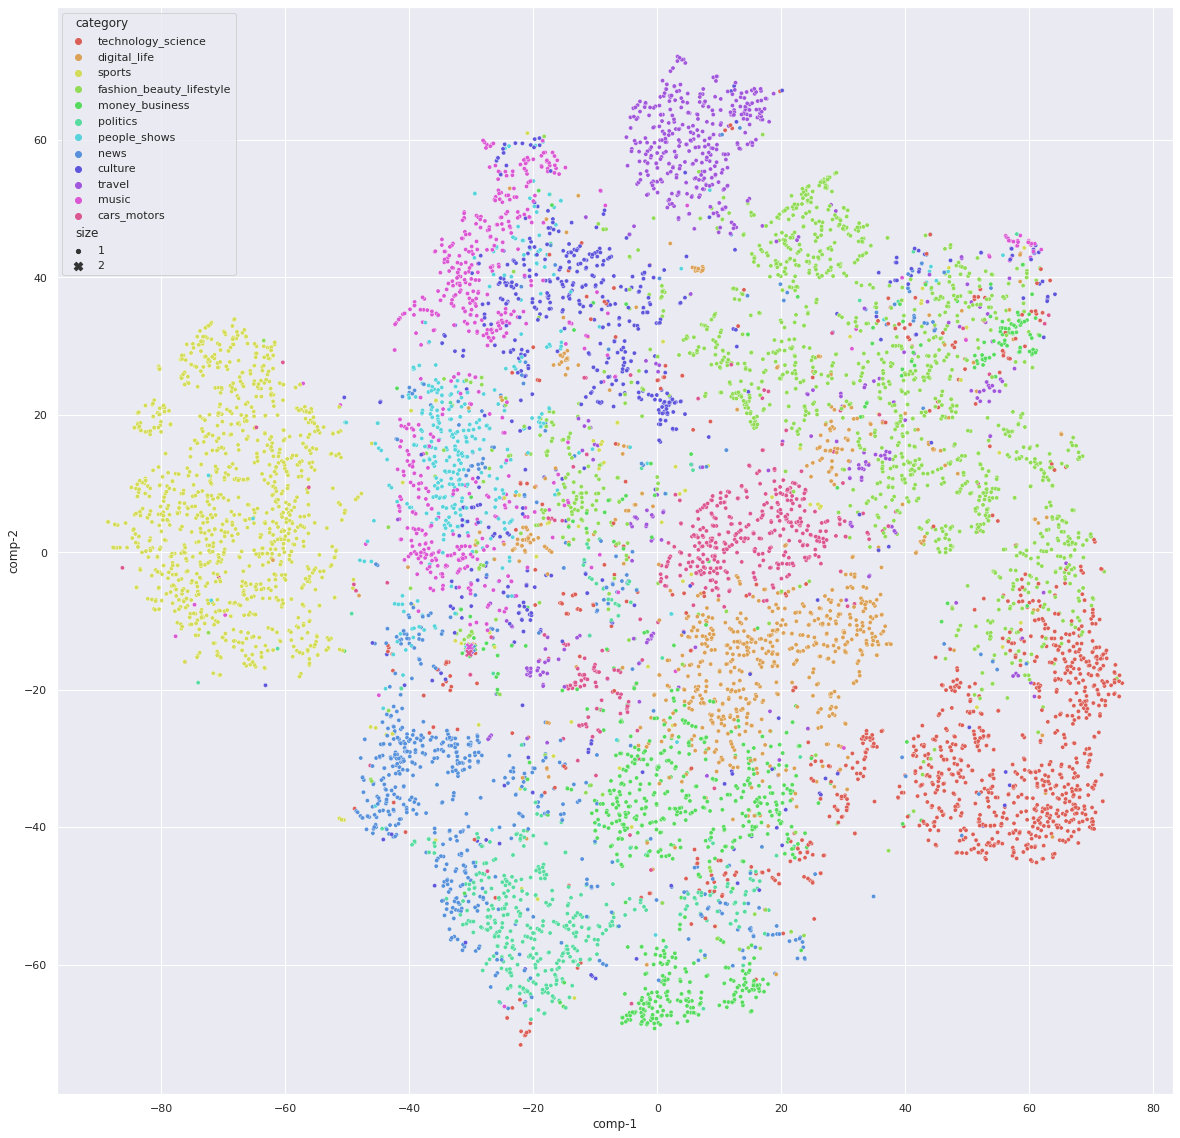

In [15]:
import seaborn as sns
sns.set(rc={'figure.figsize':(20,20)})

df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
df["size"] = 1 + 1 * (df.index < 0)
sns.scatterplot(x="comp-1", y="comp-2", 
                hue="category",
                palette=sns.color_palette("hls", n),
                data=df, size="size", style="size")

## Test

In [16]:
test = ["This dress is beutifull", '', 'iphone vs android', 'kills', 'Tesla', 'Oil price is high.', 'earth is a planet', 
        'interview', 'Google', 'footbal', 'procastination', 'depression']
cat = y_train.columns[model.predict(test).argmax(axis=1)]

list(zip(test, cat))


[('This dress is beutifull', 'fashion_beauty_lifestyle'),
 ('', 'fashion_beauty_lifestyle'),
 ('iphone vs android', 'digital_life'),
 ('kills', 'news'),
 ('Tesla', 'digital_life'),
 ('Oil price is high.', 'fashion_beauty_lifestyle'),
 ('earth is a planet', 'technology_science'),
 ('interview', 'people_shows'),
 ('Google', 'digital_life'),
 ('footbal', 'sports'),
 ('procastination', 'fashion_beauty_lifestyle'),
 ('depression', 'fashion_beauty_lifestyle')]

In [17]:
text = '''
he turning point came just after 6:30 on a Tuesday morning.

It was the 9 December 2020 and 91-year-old Margaret Keenan and 81-year-old William Shakespeare – who delighted the world by hailing from Warwickshire, like the poet – had just become the first people to ever receive an initial dose of a Covid-19 vaccine outside clinical trials.

The entire room burst into applause. The day was named "V-day", and the atmosphere was giddy. One British newspaper celebrated with the whimsical headline "The taming of the flu" – while footage of a particularly charismatic early vaccine recipient, who was more concerned about his "rather nasty lunch" than the needle went viral on Twitter. The pandemic was far from over, but this was the first step on the way out. 

Nine months later, around 5.7 billion doses of various vaccines have now been administered worldwide – with 41.8% of the global population at least partially protected. But the list of unknowns is growing by the day.

"One ghastly thing about this pandemic is that people get cross with us [scientists]," says Danny Altmann, professor of immunology at University College London, "because we change our minds, because it's such a moving target."

Now that it's clear the world is likely to be riddled with Covid-19 – and its many variant successors – for years to come, the next big question is whether two doses of each vaccine is enough.

Altmann explains that not that long ago – in April and May – he was writing articles and giving interviews saying that most vaccinated people had immunity that was so stupendous, there was no need to worry about booster doses.

"The expression I used was 'protective headroom'," says Altmann. "That you've got lots of protective headroom and even if variants come along that drop the effectiveness of your vaccine 10 times, say, because you've got a 1,000 times excess of antibodies, it wouldn't do any harm." The strong antibody response was initially reflected in their efficacy, too – while the World Health Organization (WHO) recommended approving any over 50%, in reality it was orders of magnitude higher.

Then the Delta variant came rampaging – and though most people still have high levels of antibodies, breakthrough infections are not rare events. "We're seeing breakthrough infections in the face of quite decent levels of neutralising antibodies," he says.
'''

In [18]:
y_train.columns[model.predict([text]).argmax(axis=1)]


Index(['technology_science'], dtype='object')

It works :)

Now we can use TensorFlow Serving to deploy ... 